## importation des bibliotheque

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from print_color import print
import locale 
from datetime import datetime
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')


'fr_FR.UTF-8'

In [17]:
BRVM = pd.read_csv("../new/BRVM-Agriculture.csv",index_col="Date")

In [18]:
BRVM.index.get_loc("15/05/2023")
BRVM["Close"] = BRVM["Dernier"].apply(lambda x : float(str(x).replace(",",'.')) )

In [19]:
debut = -730
fin = len(BRVM)
brvm = BRVM[["Close"]]
brvm

,Close
Date,
25/01/2023,279.25
26/01/2023,281.31
27/01/2023,275.48
30/01/2023,284.85
31/01/2023,288.31
...,...
17/08/2023,198.14
18/08/2023,196.53
21/08/2023,197.31


In [20]:
brvm['Close'].describe()

count    140.000000
mean     253.644429
std       34.358684
min      195.270000
25%      228.557500
50%      256.715000
75%      286.697500
max      296.610000
Name: Close, dtype: float64

### Calcul des moyennes mobiles longues et courtes

In [21]:
# creation de de colonne de moyenne mobile

# moyenne mobile rapide / court terme
r = 8
l = 15
brvm["MA10"] = brvm["Close"].rolling(r).mean() #10

# moyenne mobile lente / long terme
brvm["MA50"] = brvm["Close"].rolling(l).mean() #40

brvm = brvm.dropna() ;

C:\Users\steph\AppData\Local\Temp\ipykernel_10448\2877403182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brvm["MA10"] = brvm["Close"].rolling(r).mean() #10
C:\Users\steph\AppData\Local\Temp\ipykernel_10448\2877403182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brvm["MA50"] = brvm["Close"].rolling(l).mean() #40


In [22]:
# creation de la liste position
condition = [brvm["MA10"]>brvm["MA50"] , brvm["MA10"]<brvm["MA50"]]
# creation d'une liste choix de deux element
choix = [1,0]
# 
brvm['P'] = np.select(condition, choix)

C:\Users\steph\AppData\Local\Temp\ipykernel_10448\1963245404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brvm['P'] = np.select(condition, choix)


In [23]:
brvm.index

Index(['14/02/2023', '15/02/2023', '16/02/2023', '17/02/2023', '20/02/2023',
       '21/02/2023', '22/02/2023', '23/02/2023', '24/02/2023', '27/02/2023',
       ...
       '09/08/2023', '10/08/2023', '11/08/2023', '14/08/2023', '16/08/2023',
       '17/08/2023', '18/08/2023', '21/08/2023', '22/08/2023', '23/08/2023'],
      dtype='object', name='Date', length=126)

### Vérification des conditions d'achat et de vente du marché

A l'entré sur le marché nous ne pocédons pas de stock.
Au premier signal d'achat nous achetons des actifs.
Si il y a d'autre signal d'achat nous n'achetons pas car nous avons déja des actifs. 
De meme nous ne vendons pas si nous n'avons pas de stock en cas de signal de vente

In [24]:
condition = []
signal_achat = []
signal_vente = []
date_1 = brvm.index[0]
stock = 0 # permet d'eviter d'acheter quand on pas de stock au debut

for date in brvm.index :
    if brvm["MA10"].loc[date] > brvm["MA50"].loc[date] :
        condition.append(1)
    else :
        condition.append(0)
    
    if( brvm["MA10"].loc[date] > brvm["MA50"].loc[date] ) and (brvm["MA10"].loc[date_1] < brvm["MA50"].loc[date_1]) and stock == 0:
        signal_achat.append(brvm["Close"].loc[date])
        stock = 1

    else :
        signal_achat.append(np.nan)

    
    if( brvm["MA10"].loc[date] < brvm["MA50"].loc[date] ) and (brvm["MA10"].loc[date_1] > brvm["MA50"].loc[date_1]) and (stock == 1):
        signal_vente.append(brvm["Close"].loc[date])
        stock = 0
    else :
        signal_vente.append(np.nan)
    date_1 = date

brvm["Position"] = condition
        


C:\Users\steph\AppData\Local\Temp\ipykernel_10448\2984402136.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brvm["Position"] = condition


In [25]:
"""for i in range(len(brvm)-1 , 0 , -1 ) :
    if signal_achat[i] > 0 :
        signal_achat[i] = np.nan
        break
        """

'for i in range(len(brvm)-1 , 0 , -1 ) :\n    if signal_achat[i] > 0 :\n        signal_achat[i] = np.nan\n        break\n        '

In [26]:
achat_vente = []
stock = 0
for i in range( len(brvm) ) :
    if signal_achat[i] > 0 and stock != 1:
        achat_vente.append('acheter')
        stock = 1
    elif signal_vente[i] > 0 and stock != 0 :
        achat_vente.append('vendre' )
        stock=0
    else :
        achat_vente.append(np.nan)

brvm['achat_vente'] = achat_vente

C:\Users\steph\AppData\Local\Temp\ipykernel_10448\333253715.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brvm['achat_vente'] = achat_vente


In [27]:
dataf = pd.DataFrame()
dataf['date'] = brvm.index
dataf['achat'] = signal_achat
dataf['vente'] = signal_vente

u=dataf['achat'][0]
d=dataf[(dataf['achat']>0)|(dataf['vente']>0)]['date']

C:\Users\steph\AppData\Local\Temp\ipykernel_10448\1520097884.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


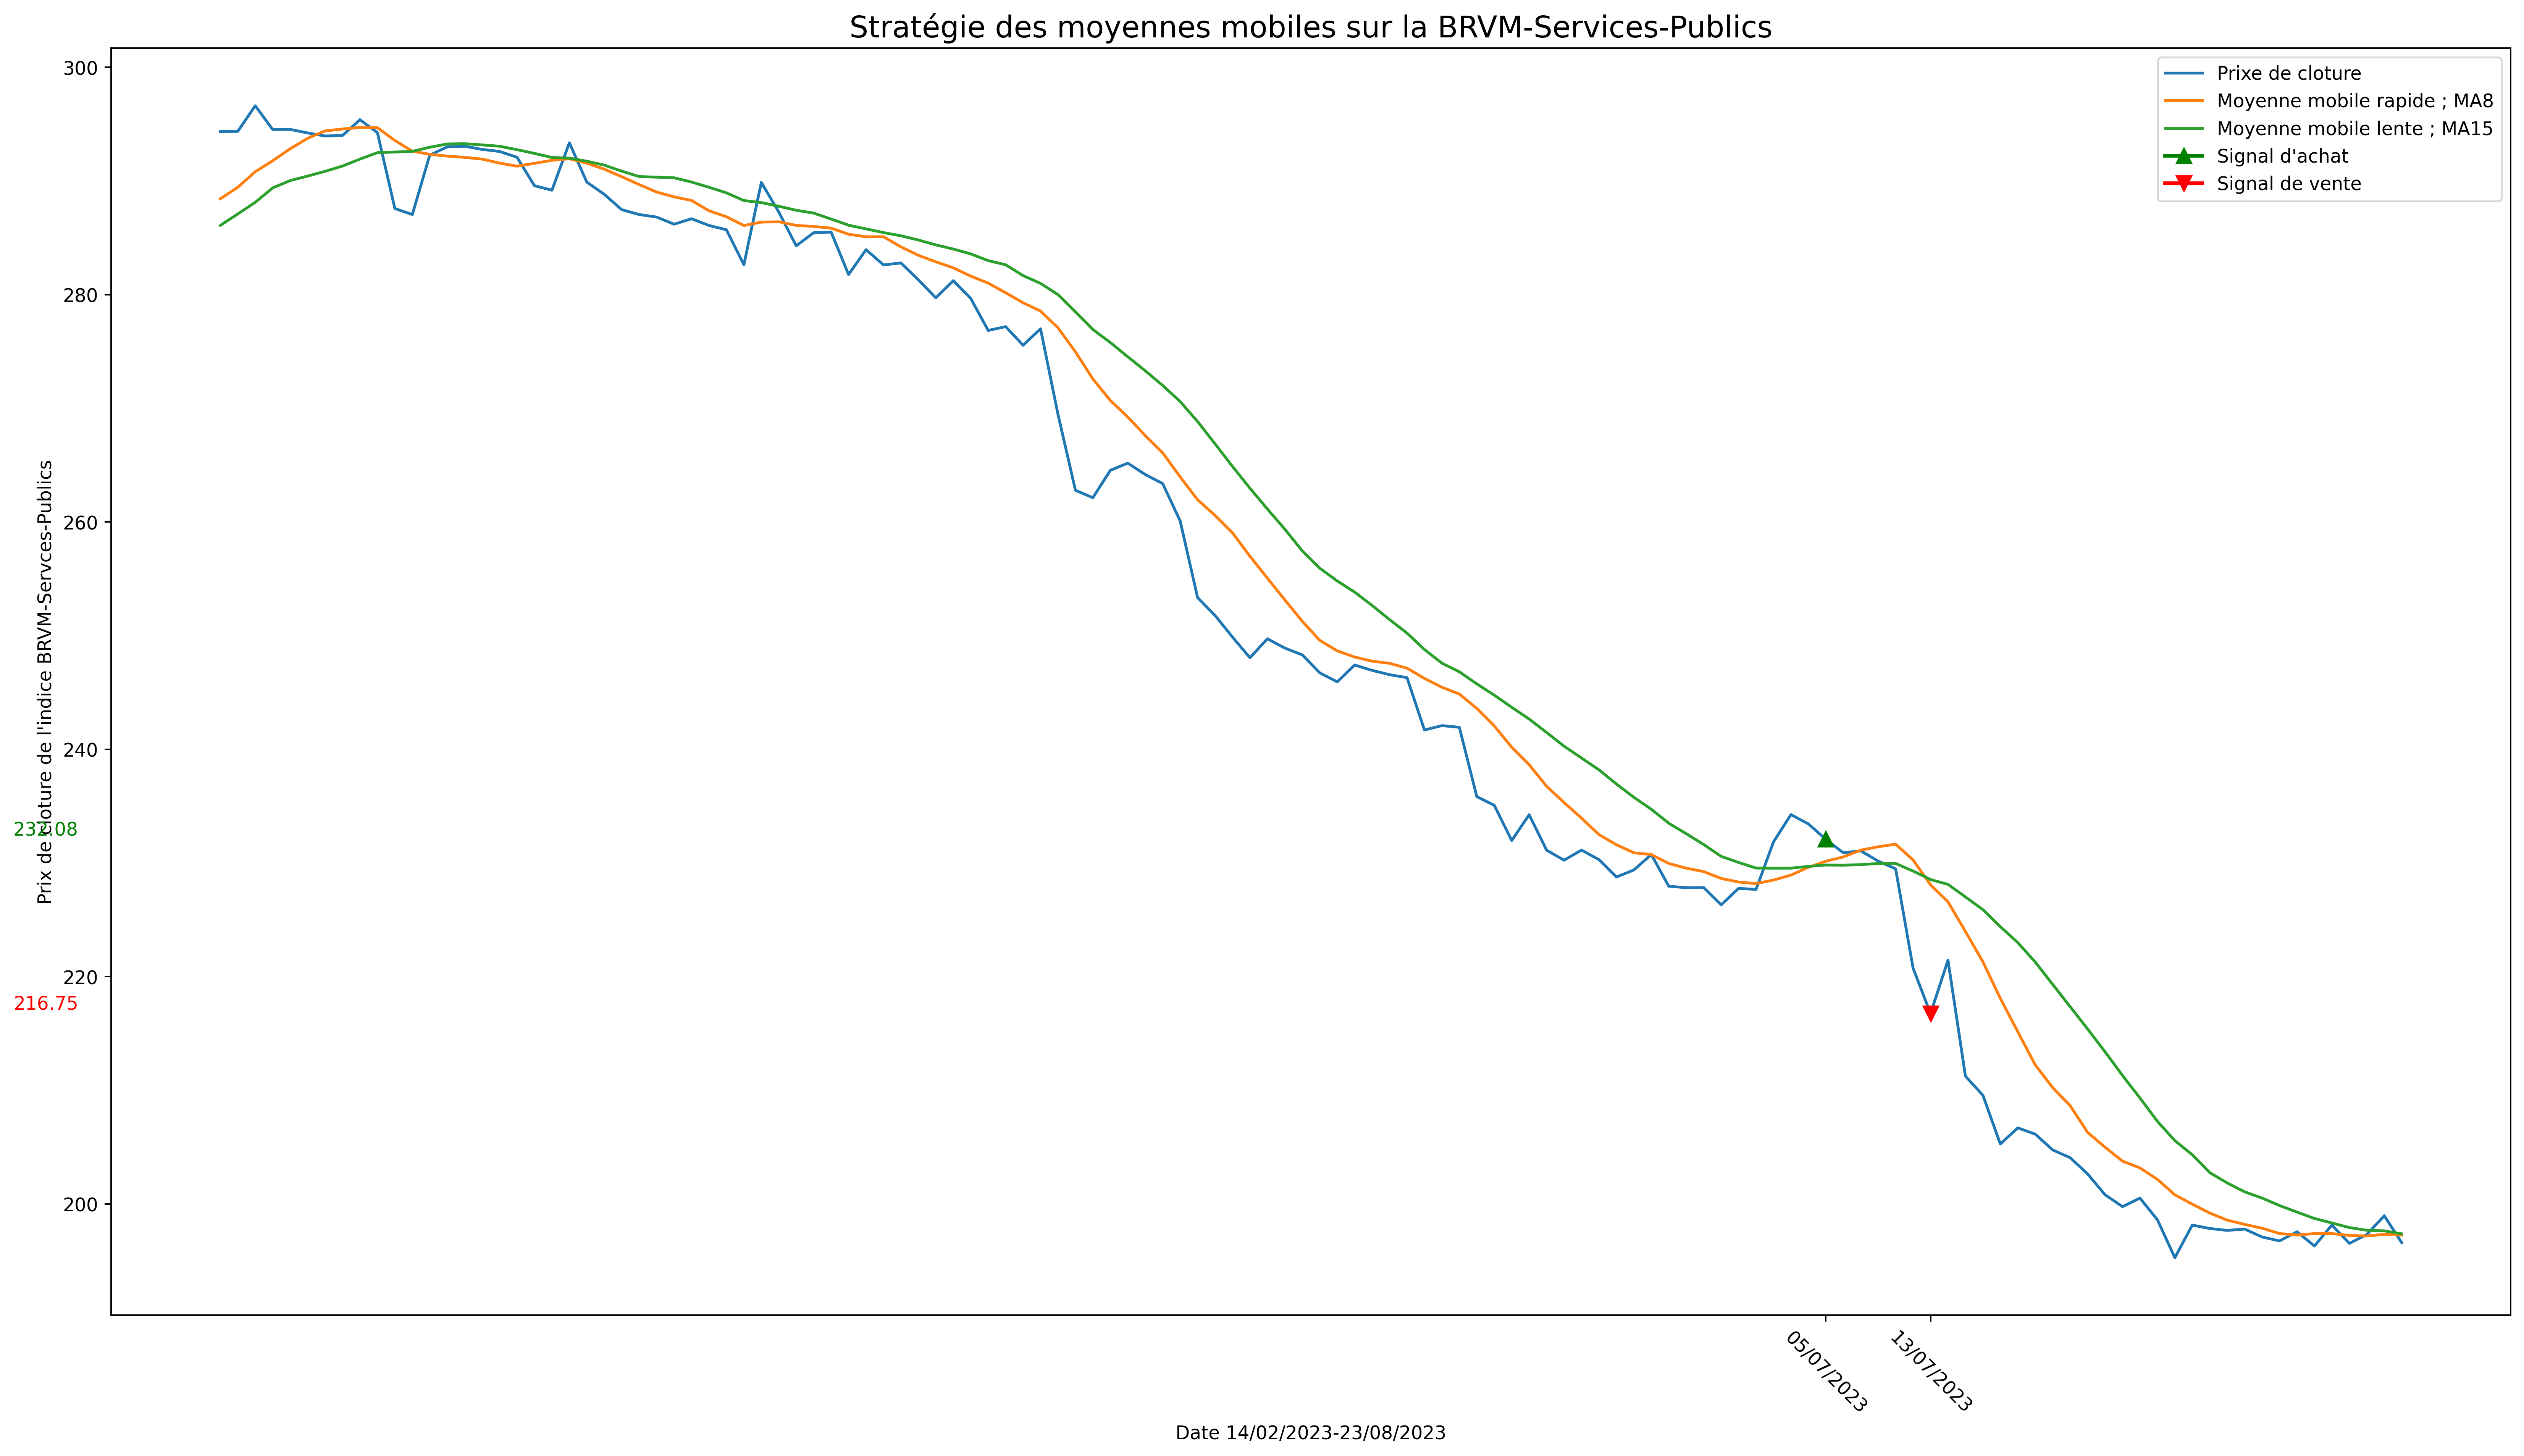

In [28]:
plt.figure(figsize=(19,11),dpi=350)
plt.plot(brvm.index , brvm["Close"] , label='Prixe de cloture' )
plt.plot(brvm.index , brvm["MA10"] , label=f'Moyenne mobile rapide ; MA{r}' )
plt.plot(brvm.index , brvm["MA50"] , label=f'Moyenne mobile lente ; MA{l}')

d=dataf[(dataf['achat']>0)|(dataf['vente']>0)]['date']
#position = [100,200,300,400,500,600]
#labels = [brvm.iloc[int(i)].name for i in position]
plt.xticks(d.index,d.values,rotation=-45)
plt.tight_layout()

plt.plot(list(brvm.index ), signal_achat , marker='^',color='green',markersize=8,label = "Signal d'achat",linewidth=2)
plt.plot(brvm.index , signal_vente , marker='v',color='red',markersize=8,label = "Signal de vente",linewidth=2)
#for i in range( len(signal_achat) ) :
 #   if signal_achat[i] > 0 :
#        plt.text(d.values[i],signal_achat[i],str(signal_achat[i]) )

j=-10
for i, yi in enumerate(signal_achat):
    if yi >0:
        plt.text(j, yi, str(yi), color='green', ha='center', va='bottom')
        j+=15

j=-10
for i, yi in enumerate(signal_vente):
    if yi >0:
        plt.text(j, yi, str(yi), color='red', ha='center', va='bottom')
        j+=15


#axe1.plot(point[1][0],point[1][1] )
plt.legend()
plt.title("Stratégie des moyennes mobiles sur la BRVM-Services-Publics" , fontsize=16) 
plt.ylabel("Prix de cloture de l'indice BRVM-Servces-Publics")
d = str(brvm.index[0]) ; 
f = str(brvm.index[len(brvm)-1])
plt.xlabel(f"Date {d}-{f}")
plt.savefig(r"C:\Users\steph\OneDrive\Documents\COURS\latex\img\MA-public.jpg")
#plt.close()
plt.tight_layout()



## Backtesting

In [29]:
benefice = 0
depart = 1000
d = depart
nombre = 0
total = 0

for i in range( len( brvm ) ) :
    if brvm['achat_vente'].iloc[i] == 'acheter' :

        nombre = depart/brvm['Close'].iloc[i]
        entrer = nombre*brvm['Close'].iloc[i]

    elif brvm['achat_vente'].iloc[i] == 'vendre' :

        sorti = (nombre*brvm['Close'].iloc[i])
        benefice += sorti-entrer
        
        total += sorti
        depart = sorti
    else :
        pass

pourcentage_befice = 100*(benefice/d)

## Resulatats du backtesting

In [30]:
date_depart = datetime.strptime(BRVM.iloc[debut].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")
date_fin = datetime.strptime(BRVM.iloc[fin-1].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")

print("Avec un capitale de depart de " ,end="")
print("{:,.2f} Fcfa".format(d) , color='green')
print("nous avons réalisé un benefice de ",end='')
print("{:.2f} %".format(pourcentage_befice) , color='green')
print("Soit un benefice total de ",end='')
print("{:,.2f} Fcfa".format(benefice) , color='green')
print("Sur la periode allant du ",end='')
print(date_depart , color="blue" , end="") ; print(" au " ,end="")
print(date_fin , color="blue" , end="")


IndexError: single positional indexer is out-of-bounds

In [ ]:
df = pd.read_csv("../test/MA_BRVM-Public-Services_train.csv")
df["ratio"] = (df["positive"]/(df['negative']+df["positive"]))*100
df['rapide2'] = df['rapide']*2
df['lente10'] = df['rapide']+10

In [ ]:
df[df['benef']==df['benef'].max()]
df['dif'] = (df['lente']>=(df['rapide']*2))

In [ ]:
print(df["benef"].max())
df0 = df[df['lente']>=df['lente10']]
print(len(df0))
df0
df1=df0[(df0['ratio']>=80)]
print(len(df1))
ma = df1[df1["benef"]>=df1["benef"].max()]
ma


9.264
2091
25


,Unnamed: 0,lente,rapide,benef,id,positive,negative,ratio,rapide2,lente10,dif
547,547,80,27,4.085,287,1,0,100.0,54,37,True
548,548,81,27,4.085,286,1,0,100.0,54,37,True


In [ ]:
print(df["benef"].max())
df0 = df[df['dif']==True]
print(len(df0))
df0
df1=df0[(df0['positive']>=3)&(df0['ratio']>=70)]
print(len(df1))
ma = df1[df1["benef"]>=(df1["benef"].max()-6)]
ma


9.264
961
0


,Unnamed: 0,lente,rapide,benef,id,positive,negative,ratio,rapide2,lente10,dif


In [ ]:
dff = pd.read_csv("../test/MA_BRVM-Public-Services_train.csv")

In [ ]:
df1=df0[(df0['ratio']>=70)]
periodes = [list(df1['lente']), list(df1['rapide']) ]
for l , r in zip( periodes[0],periodes[1] ):
    data=dff[(dff["lente"]>=l-1)&(dff["lente"]<=l+1)&(dff["rapide"]>=r-1)&(dff["rapide"]<=r+1)][["lente","rapide","benef","positive","negative"]]
    if (data['positive'].sum()/(data['positive'].sum()+data['negative'].sum()))*100 >=0:
        print((l , r) ,data['positive'].sum() , " ; " , data['negative'].sum() , " ;;; ", (data['positive'].sum()/(data['positive'].sum()+data['negative'].sum()))*100 )

(81, 26) 5  ;  4  ;;;  55.55555555555556
(82, 26) 5  ;  4  ;;;  55.55555555555556
(96, 26) 2  ;  7  ;;;  22.22222222222222
(97, 26) 3  ;  6  ;;;  33.33333333333333
(98, 26) 2  ;  7  ;;;  22.22222222222222
(80, 27) 5  ;  4  ;;;  55.55555555555556
(81, 27) 6  ;  3  ;;;  66.66666666666666
(82, 27) 5  ;  4  ;;;  55.55555555555556
(83, 27) 4  ;  5  ;;;  44.44444444444444
(84, 27) 3  ;  6  ;;;  33.33333333333333
(85, 27) 3  ;  6  ;;;  33.33333333333333
(86, 27) 3  ;  6  ;;;  33.33333333333333
(87, 27) 3  ;  6  ;;;  33.33333333333333
(88, 27) 2  ;  7  ;;;  22.22222222222222
(79, 28) 5  ;  4  ;;;  55.55555555555556
(80, 28) 5  ;  4  ;;;  55.55555555555556
(78, 29) 4  ;  5  ;;;  44.44444444444444
(79, 29) 5  ;  4  ;;;  55.55555555555556
(78, 30) 4  ;  5  ;;;  44.44444444444444
(77, 31) 4  ;  5  ;;;  44.44444444444444
(76, 32) 3  ;  6  ;;;  33.33333333333333
(77, 32) 3  ;  6  ;;;  33.33333333333333
(76, 34) 2  ;  7  ;;;  22.22222222222222
(74, 35) 2  ;  7  ;;;  22.22222222222222
(75, 35) 3  ;  6

In [ ]:
l = 75; r =46
data=dff[(dff["lente"]>=l-1)&(dff["lente"]<=l+1)&(dff["rapide"]>=r-1)&(dff["rapide"]<=r+1)][["lente","rapide","benef","positive","negative"]]
text=''
for i in range(len(data)) :
    for d in data.iloc[i]:
        if str(d)[-2:] == ".0" :
            text+=f"\t&{int(d)}"
        else :
            text+=f"\t&{d}"
        i+=1
    text+="\t\\\ \n"
print(text)
data

	&74	&45	&-5.738	&0	&1	\\ 
	&75	&45	&-5.781	&0	&1	\\ 
	&76	&45	&-8.983	&0	&1	\\ 
	&74	&46	&-5.738	&0	&1	\\ 
	&75	&46	&-8.925	&0	&1	\\ 
	&76	&46	&-8.983	&0	&1	\\ 
	&74	&47	&-8.883	&0	&1	\\ 
	&75	&47	&-8.925	&0	&1	\\ 
	&76	&47	&-8.983	&0	&1	\\ 



,lente,rapide,benef,positive,negative
1819,74,45,-5.738,0,1
1820,75,45,-5.781,0,1
1821,76,45,-8.983,0,1
1890,74,46,-5.738,0,1
1891,75,46,-8.925,0,1
1892,76,46,-8.983,0,1
1961,74,47,-8.883,0,1
1962,75,47,-8.925,0,1
1963,76,47,-8.983,0,1
